<a href="https://colab.research.google.com/github/dindamareta/Hate-Speech-Detection/blob/master/Hate_Speech_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Data Science Course - Telkom Digital Talent Incubator 2020*

Dinda Mareta Putriany
<br> DS0207

---

# Hate Speech Detection

Hate speech detection merupakan deteksi ujaran kebencian yang dilakukan oleh suatu individu atau kelompok dalam bentuk provokasi, hasutan, ataupun hinaan kepada individu atau kelompok yang lain dalam hal berbagai aspek. Pada studi kasus ini menggunakan dataset dari https://github.com/ialfina/id-hatespeech-detection yang sebelumnya saya ubah menjadi .csv. Dataset berupa text dari tweet personal akun di twitter. Tujuan dari studi kasus ini adalah melakukan text mining untuk memprediksi text termasuk ujaran kebencian (Hate Speech) atau bukan ujaran kebencian (Non-Hate Speech). Tweet akan diprediksi menggunakan metode klasifikasi Random Forest, KNN, dan Naive Bayes.   

### *Import Library*

In [1]:
# Install Library
! pip install nltk
! pip install Sastrawi

In [49]:
# Import Library
import nltk
import re
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
import string 
import matplotlib.pyplot as plt

### *Import Dataset*

Data memiliki 2 atribut, yaitu **label** dan **tweet**.  Atribut **‘label’** sebagai target yang terdiri atas kelas **‘HS’ (Hate Speech)** dan **‘Non_HS (Non-Hate Speech)’**. Sedangkan Atribut **‘tweet’** berisi text tweet.

In [3]:
# Import Data 
df = pd.read_csv('https://raw.githubusercontent.com/dindamareta/Hate-Speech-Detection/master/IDHSD_RIO_unbalanced_713_2017.csv')

# Show 5 first Row
df.head()

,Label,Tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...


### Menampilkan Informasi Data

In [4]:
# Prints the Dataset Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   713 non-null    object
 1   Tweet   713 non-null    object
dtypes: object(2)
memory usage: 11.3+ KB


Dari informasi di atas, diketahui bahwa terdapat 713 data dengan tipe data yaitu objek. Selain itu diketahui bahwa dataset tidak memiliki data yang kosong

Non_HS    453
HS        260
Name: Label, dtype: int64




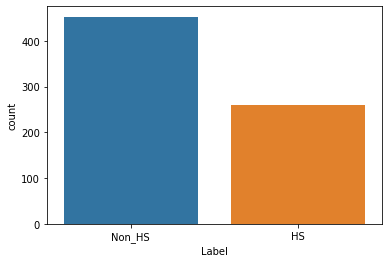

In [5]:
# Menghitung jumlah data pada atribut gender dan melihat perbandingannya
print(df['Label'].value_counts())
print('\n')
sns.countplot(x='Label', data=df)

Dari informasi di atas diketahui bahwa jumlah data dengan kelas HS berjumlah 260 dan kelas Non_HS berjumlah 453.

### Text Preprocessing

Tujuan dari text preprocessing adalah untuk membuat text menjadi lebih ideal sebelum masuk ke proses klasifikasi.

#### Case Folding

Case Folding dibutuhkan dalam mengkonversi keseluruhan teks dalam dokumen menjadi suatu bentuk standar.

In [6]:
# Mengubah teks menjadi lowercase
df['Case_Folding'] = df['Tweet'].str.lower()

In [7]:
# Menghapus angka
def remove_number(tweet):
  rem_num = re.sub(r"\d+", "", tweet)
  return rem_num

# Menghapus tanda baca
def remove_punctuation(tweet):
  rem_punct  = tweet.translate(str.maketrans("","",string.punctuation))
  return rem_punct

# Menghapus whitepace (karakter kosong)
def remove_whitespace(tweet):
  rem_white = tweet.strip()
  return rem_white

# Menghapus tab, line baru, back slice
def remove_tabline(tweet):
  rem_tab = tweet.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
  return rem_tab

# Menghapus non ASCII (emoticon, dll)
def remove_nonascii(tweet):
  rem_nonascii = tweet.encode('ascii', 'replace').decode('ascii')
  return rem_nonascii

# Menghapus mention, link dan hastag
def remove_mention(tweet):
  rem_mt = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", tweet).split())
  return rem_mt

# Menghapus URL
def remove_url(tweet):
  rem_url = tweet.replace("http://", " ").replace("https://", " ")
  return rem_url
  
# Menghapus RT
def remove_RT(tweet):
  rem_RT = re.sub(r'^rt[\s]+', '', tweet)
  return rem_RT



In [ ]:
# Memanggil seluruh function di atas
df['Case_Folding'] = df['Case_Folding'].apply(remove_tabline)       # function remove_tabline
df['Case_Folding'] = df['Case_Folding'].apply(remove_nonascii)      # function remove_nonascii
df['Case_Folding'] = df['Case_Folding'].apply(remove_mention)       # function remove_mention
df['Case_Folding'] = df['Case_Folding'].apply(remove_url)           # function remove_url
df['Case_Folding'] = df['Case_Folding'].apply(remove_number)        # function remove_number
df['Case_Folding'] = df['Case_Folding'].apply(remove_punctuation)   # function remove_punctuation
df['Case_Folding'] = df['Case_Folding'].apply(remove_whitespace)    # function remove_whitespace
df['Case_Folding'] = df['Case_Folding'].apply(remove_RT)            # function remove_RT

In [9]:
df

,Label,Tweet,Case_Folding
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,fadli zon minta mendagri segera menonaktifkan ...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,mereka terus melukai aksi dalam rangka memenja...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,sylvi bagaimana gurbernur melakukan kekerasan ...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",ahmad dhani tak puas debat pilkada masalah jal...
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,waspada ktp palsukawal pilkada
...,...,...,...
708,HS,Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....,muka si babi ahok tuh yg mirip serbet lantai btp
709,HS,"Betul bang hancurkan merka bang, musnahkan chi...",betul bang hancurkan merka bang musnahkan chin...
710,HS,"Sapa Yg bilang Ahok anti korupsi!?, klo grombo...",sapa yg bilang ahok anti korupsi klo grombolan...
711,HS,"Gw juga ngimpi SENTILIN BIJI BABI AHOK, pcetar...",gw juga ngimpi sentilin biji babi ahok pcetar ...


#### Tokenization

Tokenizing adalah tahap pemotongan string input berdasarkan tiap kata yang menyusunnya. Secara garis besar memecah sekumpulan karakter dalam suatu teks ke dalam satuan kata.

In [10]:
# Membuat function tokenization
def tokenization(tweet):
  tokens = nltk.tokenize.word_tokenize(tweet)
  return tokens

In [11]:
# Memanggil function tokenization
df['Tokenization'] = df['Case_Folding'].apply(tokenization)

In [12]:
df

,Label,Tweet,Case_Folding,Tokenization
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,fadli zon minta mendagri segera menonaktifkan ...,"[fadli, zon, minta, mendagri, segera, menonakt..."
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,mereka terus melukai aksi dalam rangka memenja...,"[mereka, terus, melukai, aksi, dalam, rangka, ..."
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,sylvi bagaimana gurbernur melakukan kekerasan ...,"[sylvi, bagaimana, gurbernur, melakukan, keker..."
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",ahmad dhani tak puas debat pilkada masalah jal...,"[ahmad, dhani, tak, puas, debat, pilkada, masa..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,waspada ktp palsukawal pilkada,"[waspada, ktp, palsukawal, pilkada]"
...,...,...,...,...
708,HS,Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....,muka si babi ahok tuh yg mirip serbet lantai btp,"[muka, si, babi, ahok, tuh, yg, mirip, serbet,..."
709,HS,"Betul bang hancurkan merka bang, musnahkan chi...",betul bang hancurkan merka bang musnahkan chin...,"[betul, bang, hancurkan, merka, bang, musnahka..."
710,HS,"Sapa Yg bilang Ahok anti korupsi!?, klo grombo...",sapa yg bilang ahok anti korupsi klo grombolan...,"[sapa, yg, bilang, ahok, anti, korupsi, klo, g..."
711,HS,"Gw juga ngimpi SENTILIN BIJI BABI AHOK, pcetar...",gw juga ngimpi sentilin biji babi ahok pcetar ...,"[gw, juga, ngimpi, sentilin, biji, babi, ahok,..."


#### Filtering (Stopword Removal)

Filtering adalah tahap mengambil kata-kata penting dari hasil token. Bisa menggunakan algoritma stoplist (membuang kata kurang penting) atau wordlist (menyimpan kata penting). Stoplist/stopword adalah kata-kata yang tidak deskriptif yang dapat dibuang dalam pendekatan bag-of-words.

In [13]:
# Mmebuat function stopword
listStopword =  stopwords.words('indonesian')
listStopword.extend(['gw','yg','klo','dg','jg','nih','si','aja','yng','y','tuh','cm','td','sm','lo','loh','jga'])
def stopw(text):
  removed = []
  for t in text:
      if t not in listStopword:
          removed.append(t)
  return removed

In [14]:
# Memanggil funtion stopword
df['Stopword'] = df['Tokenization'].apply(stopw)

In [15]:
df

,Label,Tweet,Case_Folding,Tokenization,Stopword
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,fadli zon minta mendagri segera menonaktifkan ...,"[fadli, zon, minta, mendagri, segera, menonakt...","[fadli, zon, mendagri, menonaktifkan, ahok, gu..."
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,mereka terus melukai aksi dalam rangka memenja...,"[mereka, terus, melukai, aksi, dalam, rangka, ...","[melukai, aksi, rangka, memenjarakan, ahok, ah..."
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,sylvi bagaimana gurbernur melakukan kekerasan ...,"[sylvi, bagaimana, gurbernur, melakukan, keker...","[sylvi, gurbernur, kekerasan, perempuan, bukti..."
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",ahmad dhani tak puas debat pilkada masalah jal...,"[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, puas, debat, pilkada, jalan, be..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,waspada ktp palsukawal pilkada,"[waspada, ktp, palsukawal, pilkada]","[waspada, ktp, palsukawal, pilkada]"
...,...,...,...,...,...
708,HS,Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....,muka si babi ahok tuh yg mirip serbet lantai btp,"[muka, si, babi, ahok, tuh, yg, mirip, serbet,...","[muka, babi, ahok, serbet, lantai, btp]"
709,HS,"Betul bang hancurkan merka bang, musnahkan chi...",betul bang hancurkan merka bang musnahkan chin...,"[betul, bang, hancurkan, merka, bang, musnahka...","[bang, hancurkan, merka, bang, musnahkan, chin..."
710,HS,"Sapa Yg bilang Ahok anti korupsi!?, klo grombo...",sapa yg bilang ahok anti korupsi klo grombolan...,"[sapa, yg, bilang, ahok, anti, korupsi, klo, g...","[sapa, bilang, ahok, anti, korupsi, grombolann..."
711,HS,"Gw juga ngimpi SENTILIN BIJI BABI AHOK, pcetar...",gw juga ngimpi sentilin biji babi ahok pcetar ...,"[gw, juga, ngimpi, sentilin, biji, babi, ahok,...","[ngimpi, sentilin, biji, babi, ahok, pcetar, p..."


#### Stemming

Stemming adalah proses menghilangkan infleksi kata ke bentuk dasarnya, namun bentuk dasar tersebut tidak berarti sama dengan akar kata (root word).

In [16]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
df['Stemming'] = df['Stopword'].apply(lambda x: [stemmer.stem(y) for y in x])

In [17]:
df

,Label,Tweet,Case_Folding,Tokenization,Stopword,Stemming
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,fadli zon minta mendagri segera menonaktifkan ...,"[fadli, zon, minta, mendagri, segera, menonakt...","[fadli, zon, mendagri, menonaktifkan, ahok, gu...","[fadli, zon, mendagri, nonaktif, ahok, gubernu..."
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,mereka terus melukai aksi dalam rangka memenja...,"[mereka, terus, melukai, aksi, dalam, rangka, ...","[melukai, aksi, rangka, memenjarakan, ahok, ah...","[luka, aksi, rangka, penjara, ahok, ahok, gaga..."
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,sylvi bagaimana gurbernur melakukan kekerasan ...,"[sylvi, bagaimana, gurbernur, melakukan, keker...","[sylvi, gurbernur, kekerasan, perempuan, bukti...","[sylvi, gurbernur, keras, perempuan, bukti, fo..."
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",ahmad dhani tak puas debat pilkada masalah jal...,"[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, puas, debat, pilkada, jalan, be...","[ahmad, dhani, puas, debat, pilkada, jalan, be..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,waspada ktp palsukawal pilkada,"[waspada, ktp, palsukawal, pilkada]","[waspada, ktp, palsukawal, pilkada]","[waspada, ktp, palsukawal, pilkada]"
...,...,...,...,...,...,...
708,HS,Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....,muka si babi ahok tuh yg mirip serbet lantai btp,"[muka, si, babi, ahok, tuh, yg, mirip, serbet,...","[muka, babi, ahok, serbet, lantai, btp]","[muka, babi, ahok, serbet, lantai, btp]"
709,HS,"Betul bang hancurkan merka bang, musnahkan chi...",betul bang hancurkan merka bang musnahkan chin...,"[betul, bang, hancurkan, merka, bang, musnahka...","[bang, hancurkan, merka, bang, musnahkan, chin...","[bang, hancur, merka, bang, musnah, china, bab..."
710,HS,"Sapa Yg bilang Ahok anti korupsi!?, klo grombo...",sapa yg bilang ahok anti korupsi klo grombolan...,"[sapa, yg, bilang, ahok, anti, korupsi, klo, g...","[sapa, bilang, ahok, anti, korupsi, grombolann...","[sapa, bilang, ahok, anti, korupsi, grombolann..."
711,HS,"Gw juga ngimpi SENTILIN BIJI BABI AHOK, pcetar...",gw juga ngimpi sentilin biji babi ahok pcetar ...,"[gw, juga, ngimpi, sentilin, biji, babi, ahok,...","[ngimpi, sentilin, biji, babi, ahok, pcetar, p...","[ngimpi, sentilin, biji, babi, ahok, pcetar, p..."


### Memilih Fitur dan Target

Melakukan drop pada atribut Tweet, Case_Folding, Tokenization, dan Stopword karena hasil akhir dari text preprocessing adalah stemming (sudah mencakup preprocessing sebelumnya).

In [18]:
df_feat = df.drop(['Tweet','Case_Folding','Tokenization','Stopword'], axis=1)

In [19]:
df_feat

,Label,Stemming
0,Non_HS,"[fadli, zon, mendagri, nonaktif, ahok, gubernu..."
1,Non_HS,"[luka, aksi, rangka, penjara, ahok, ahok, gaga..."
2,Non_HS,"[sylvi, gurbernur, keras, perempuan, bukti, fo..."
3,Non_HS,"[ahmad, dhani, puas, debat, pilkada, jalan, be..."
4,Non_HS,"[waspada, ktp, palsukawal, pilkada]"
...,...,...
708,HS,"[muka, babi, ahok, serbet, lantai, btp]"
709,HS,"[bang, hancur, merka, bang, musnah, china, bab..."
710,HS,"[sapa, bilang, ahok, anti, korupsi, grombolann..."
711,HS,"[ngimpi, sentilin, biji, babi, ahok, pcetar, p..."


Setelah itu melakukan penghapusan tanda baca dengan function remove_punctuation(), melakukan drop pada atribut Stemming, dan mengubah label HS --> 1 dan Non_HS --> 0

In [20]:
# Function remove punctuation 2
def remove_punct(tweet):
    tweet  = " ".join([char for char in tweet if char not in string.punctuation])
    return tweet

In [21]:
df_feat['Tweet_Feature'] = df['Stemming'].apply(remove_punct)
df_feat = df_feat.drop(['Stemming'], axis=1)

In [22]:
# Ubah Label
df_feat['Label'].replace('Non_HS',0, inplace=True)
df_feat['Label'].replace('HS',1, inplace=True)

In [23]:
df_feat

,Label,Tweet_Feature
0,0,fadli zon mendagri nonaktif ahok gubernur dki
1,0,luka aksi rangka penjara ahok ahok gagal pilkada
2,0,sylvi gurbernur keras perempuan bukti foto bareng
3,0,ahmad dhani puas debat pilkada jalan bekas ungkap
4,0,waspada ktp palsukawal pilkada
...,...,...
708,1,muka babi ahok serbet lantai btp
709,1,bang hancur merka bang musnah china babi bumi ...
710,1,sapa bilang ahok anti korupsi grombolannya ngo...
711,1,ngimpi sentilin biji babi ahok pcetar pcetar l...


In [24]:
feature = df_feat['Tweet_Feature']     # Memilih atribut untuk fitur
target = df_feat['Label']              # Memilih atribut untuk target

### Feature Extraction, Set Data Train & Test

Langkah ini digunakan untuk membagi data ke dalam data train dan data test dengan perbandingan 70:30 sebelum dilakukan klasifikasi. Karena data setiap kelas tidak seimbang, sehingga menggunakan stratify agar pembagian data menjadi seimbang di setiap kelasnya.

In [25]:
# Set Training and Testing Data (70:30)
X_trainf, X_testf, y_train, y_test  = train_test_split(feature , target, shuffle = True, test_size=0.3, stratify = target, random_state=100)

# Show the Training and Testing Data
print(X_trainf.shape)
print(X_testf.shape)
print(y_train.shape)
print(y_test.shape)

(499,)
(214,)
(499,)
(214,)


In [26]:
# Feature Extraction
vectorizer = TfidfVectorizer()
vectorizer.fit(X_trainf)

X_train = vectorizer.transform(X_trainf).toarray()
X_test = vectorizer.transform(X_testf).toarray()

### Classification

#### Random Forest

In [27]:
# Modeling Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

# Predict to Test Data
y_pred_rf= rf.predict(X_test)

Model Evaluation

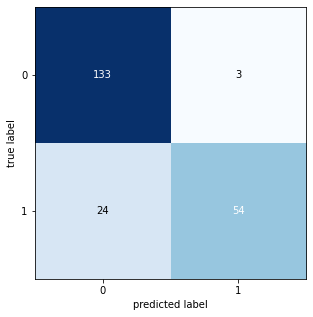

In [30]:
# Show the Confussion Matrix
cm1 = metrics.confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm1, figsize=(5,5))
plt.show()

In [31]:
# Print Classification Report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       136
           1       0.95      0.69      0.80        78

    accuracy                           0.87       214
   macro avg       0.90      0.84      0.85       214
weighted avg       0.88      0.87      0.87       214



In [32]:
# Show the Accuracy, Precision, Recall
acc_rf = metrics.accuracy_score(y_test, y_pred_rf)
prec_rf = metrics.precision_score(y_test, y_pred_rf)
rec_rf = metrics.recall_score(y_test, y_pred_rf)
f1_rf = metrics.f1_score(y_test, y_pred_rf)
kappa_rf = metrics.cohen_kappa_score(y_test, y_pred_rf)

print("Accuracy:", acc_rf)
print("Precision:", prec_rf)
print("Recall:", rec_rf)
print("F1 Score:", f1_rf)
print("Cohens Kappa Score:", kappa_rf)

Accuracy: 0.8738317757009346
Precision: 0.9473684210526315
Recall: 0.6923076923076923
F1 Score: 0.7999999999999999
Cohens Kappa Score: 0.7110711071107111


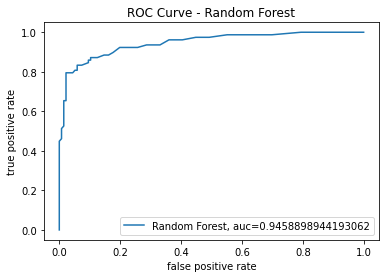

In [33]:
# ROC Curve
y_pred_rf_proba = rf.predict_proba(X_test)[::,1]
fprrf, tprrf, _ = metrics.roc_curve(y_test,  y_pred_rf_proba)
aucrf = metrics.roc_auc_score(y_test, y_pred_rf_proba)
plt.plot(fprrf,tprrf,label="Random Forest, auc="+str(aucrf))
plt.title('ROC Curve - Random Forest')
plt.xlabel('false positive rate') 
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()

#### KNN

In [34]:
# Modeling KNN
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

# Predict to Test Data
y_pred_knn= knn.predict(X_test)

Model Evaluation

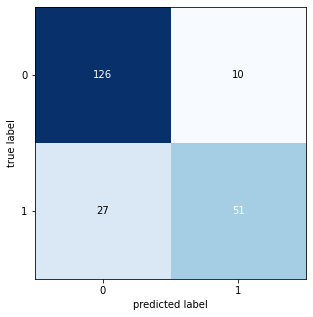

In [35]:
# Show the Confussion Matrix
cm2 = metrics.confusion_matrix(y_test, y_pred_knn)
plot_confusion_matrix(cm2, figsize=(5,5))
plt.show()

In [36]:
# Print Classification Report
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       136
           1       0.84      0.65      0.73        78

    accuracy                           0.83       214
   macro avg       0.83      0.79      0.80       214
weighted avg       0.83      0.83      0.82       214



In [37]:
# Show the Accuracy, Precision, Recall
acc_knn = metrics.accuracy_score(y_test, y_pred_knn)
prec_knn = metrics.precision_score(y_test, y_pred_knn)
rec_knn = metrics.recall_score(y_test, y_pred_knn)
f1_knn = metrics.f1_score(y_test, y_pred_knn)
kappa_knn = metrics.cohen_kappa_score(y_test, y_pred_knn)

print("Accuracy:", acc_knn)
print("Precision:", prec_knn)
print("Recall:", rec_knn)
print("F1 Score:", f1_knn)
print("Cohens Kappa Score:", kappa_knn)

Accuracy: 0.8271028037383178
Precision: 0.8360655737704918
Recall: 0.6538461538461539
F1 Score: 0.7338129496402876
Cohens Kappa Score: 0.608601087493821


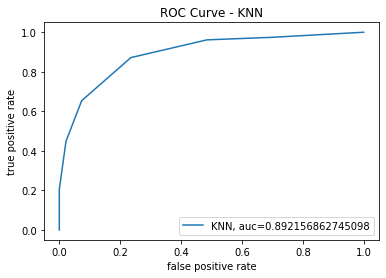

In [38]:
# ROC Curve
y_pred_knn_proba = knn.predict_proba(X_test)[::,1]
fprknn, tprknn, _ = metrics.roc_curve(y_test,  y_pred_knn_proba)
aucknn = metrics.roc_auc_score(y_test, y_pred_knn_proba)
plt.plot(fprknn,tprknn,label="KNN, auc="+str(aucknn))
plt.title('ROC Curve - KNN')
plt.xlabel('false positive rate') 
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()

#### Naive Bayes

In [41]:
# Modeling Naive Bayes Classifier
gnb = MultinomialNB()
gnb.fit(X_train, y_train)

# Predict to Test Data
y_pred_gnb= gnb.predict(X_test)

Model Evaluation

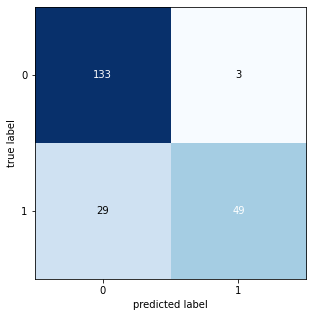

In [42]:
# Show the Confussion Matrix
cm3 = metrics.confusion_matrix(y_test, y_pred_gnb)
plot_confusion_matrix(cm3, figsize=(5,5))
plt.show()

In [43]:
# Print Classification Report
print(classification_report(y_test, y_pred_gnb))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89       136
           1       0.94      0.63      0.75        78

    accuracy                           0.85       214
   macro avg       0.88      0.80      0.82       214
weighted avg       0.87      0.85      0.84       214



In [44]:
# Show the Accuracy, Precision, Recall
acc_gnb = metrics.accuracy_score(y_test, y_pred_gnb)
prec_gnb = metrics.precision_score(y_test, y_pred_gnb)
rec_gnb = metrics.recall_score(y_test, y_pred_gnb)
f1_gnb = metrics.f1_score(y_test, y_pred_gnb)
kappa_gnb = metrics.cohen_kappa_score(y_test, y_pred_gnb)

print("Accuracy:", acc_gnb)
print("Precision:", prec_gnb)
print("Recall:", rec_gnb)
print("F1 Score:", f1_gnb)
print("Cohens Kappa Score:", kappa_gnb)

Accuracy: 0.8504672897196262
Precision: 0.9423076923076923
Recall: 0.6282051282051282
F1 Score: 0.7538461538461538
Cohens Kappa Score: 0.6525268926324335


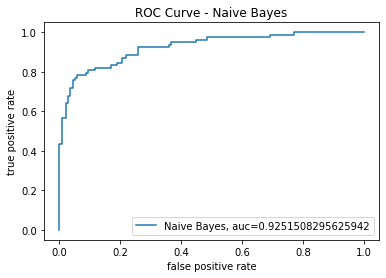

In [45]:
# ROC Curve
y_pred_gnb_proba = gnb.predict_proba(X_test)[::,1]
fprgnb, tprgnb, _ = metrics.roc_curve(y_test,  y_pred_gnb_proba)
aucgnb = metrics.roc_auc_score(y_test, y_pred_gnb_proba)
plt.plot(fprgnb,tprgnb,label="Naive Bayes, auc="+str(aucgnb))
plt.title('ROC Curve - Naive Bayes')
plt.xlabel('false positive rate') 
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()

#### Perbandingan Classification Report

In [46]:
# Comparing Model Performance
print("Random Forest Accuracy =", acc_rf)
print("Random Forest Precision =", prec_rf)
print("Random Forest Recall =", rec_rf)
print("Random Forest F1-Score =", f1_rf)
print("_______________________")
print("KNN Accuracy =", acc_knn)
print("KNN Precision =", prec_knn)
print("KNN Recall =", rec_knn)
print("KNN F1-Score =", f1_knn)
print("_______________________")
print("Naive Bayes Accuracy =", acc_gnb)
print("Naive Bayes Precision =", prec_gnb)
print("Naive Bayes Recall =", rec_gnb)
print("Naive Bayes F1-Score =", f1_gnb)

Random Forest Accuracy = 0.8738317757009346
Random Forest Precision = 0.9473684210526315
Random Forest Recall = 0.6923076923076923
Random Forest F1-Score = 0.7999999999999999
_______________________
KNN Accuracy = 0.8271028037383178
KNN Precision = 0.8360655737704918
KNN Recall = 0.6538461538461539
KNN F1-Score = 0.7338129496402876
_______________________
Naive Bayes Accuracy = 0.8504672897196262
Naive Bayes Precision = 0.9423076923076923
Naive Bayes Recall = 0.6282051282051282
Naive Bayes F1-Score = 0.7538461538461538


#### Perbandingan ROC Curve

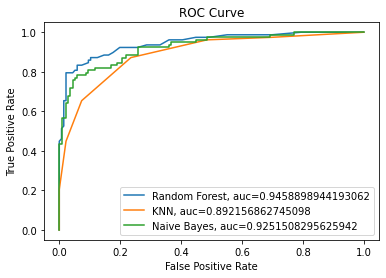

In [47]:
# Comparing ROC Curve
plt.plot(fprrf,tprrf,label="Random Forest, auc="+str(aucrf))
plt.plot(fprknn,tprknn,label="KNN, auc="+str(aucknn))
plt.plot(fprgnb,tprgnb,label="Naive Bayes, auc="+str(aucgnb))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

### Kesimpulan

Berdasarkan perbandingan 3 model yang telah dilakukan, didapatkan hasil terbaik yaitu performansi pada Random Forest. Hal ini berarti Random Forest adalah algoritma klasifikasi paling baik untuk prediksi hate speech menggunakan dataset ini. Berikut merupakan rincian performansi yang telah dihitung. <br>
Accuracy Random Forest = 87,38%, <br>
Precision Random Forest = 94.74%, <br>
Recall Random Forest = 69.23%%, <br>
F1-Score Random Forest = 79.99%, <br>
AUC Random Forest = 94.59%.